**TRANSCRIPCIÓN DE VOZ A TEXTO**

Instalacion de dependencias e importación de librerías

In [ ]:
#!pip install openai-whisper pydub ffmpeg jiwer google-cloud-speech matplotlib nltk --no-cache-dir

In [101]:
# Instalación de dependencias

# Importar librerías necesarias
import whisper
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import difflib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from google.colab import files
from jiwer import wer, cer, wil
from google.cloud import speech
from IPython.core.display import display, HTML
import pandas as pd
import librosa
from tqdm import tqdm

C:\Users\Pedro\AppData\Local\Temp\ipykernel_15188\3194268612.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


Descargar stopwords de NLTK

In [109]:
nltk.download('stopwords')
nltk.download('punkt')
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Preprocesamiento del texto

In [3]:
def preprocess_text(text, apply_preprocessing):
    """Preprocesa el texto eliminando stopwords y normalizando mayúsculas/minúsculas si el usuario lo desea."""
    if apply_preprocessing:
        text = text.lower()
        words = word_tokenize(text)
        filtered_words = [word for word in words if word.isalnum() and word not in spanish_stopwords]
        return " ".join(filtered_words)
    return text

Permitir al usuario elegir si quiere preprocesar el texto

In [4]:
apply_preprocessing = input("¿Deseas aplicar preprocesamiento (stopwords, minúsculas, etc.)? (sí/no): ").strip().lower() == "sí"

Cargar un archivo de audio

In [66]:
dataset_sp = pd.read_csv(r'F:\common_voice\Proyecto\audios\es\validated.tsv', sep ='\t')[['path','sentence']]

In [69]:
dataset_sp['path_todo'] = dataset_sp['path'].map(lambda x: os.path.join(r'F:\common_voice\Proyecto\audios\es\clips',x))

In [74]:
dataset_sp['is_in'] = [os.path.isfile(os.path.join(r'F:\common_voice\Proyecto\audios\es\clips',i)) for i in dataset_sp['path']]

In [ ]:
dataset_transc = dataset_sp[dataset_sp['is_in'] == True].sample(1000)
dataset_transc['path_todo'] = [os.path.join(r'F:\common_voice\Proyecto\audios\es\clips',i) for i in dataset_transc['path']]
dataset_transc['path'] = dataset_transc['path_todo']
dataset_transc = dataset_transc[['path','sentence']]

Cargar un archivo con el ground truth

Transcripciones

In [123]:
def evaluate_transcription(reference, hypothesis):
    """Calcula métricas de comparación entre transcripción y ground truth."""
    reference = preprocess_text(reference, apply_preprocessing)
    hypothesis = preprocess_text(hypothesis, apply_preprocessing)
    error_rates = {
        "WER": wer(reference, hypothesis),
        "CER": cer(reference, hypothesis),
        "WIL": wil(reference, hypothesis)
    }
    return error_rates

def highlight_differences(reference, hypothesis):
    """Resalta diferencias entre el texto original y la transcripción."""
    reference = preprocess_text(reference, apply_preprocessing)
    hypothesis = preprocess_text(hypothesis, apply_preprocessing)
    diff = difflib.ndiff(reference.split(), hypothesis.split())
    highlighted_text = " ".join([f"<span style='color:red'>{word}</span>" if word.startswith('-') else
                                  f"<span style='color:green'>{word}</span>" if word.startswith('+') else word[2:]
                                  for word in diff])
    return highlighted_text

# Transcripciones
transcriptions = {}

Probar modelos seleccionados

In [124]:
model = whisper.load_model('medium')

In [104]:
def transcribe_batch(dataframe):
    transcripciones = []
    ground_truths = [i for i in dataframe['sentence']]
    for i in tqdm(dataframe['path']):
        audio_file,_ = librosa.load(i,sr = 16000)
        result = model.transcribe(audio_file, language = 'es')
        transcripciones.append(result["text"])
        #print(result['text'])
    
    return transcripciones, ground_truths

In [105]:
transc,ground_truth = transcribe_batch(dataset_transc.sample(200))

100%|██████████| 200/200 [01:45<00:00,  1.90it/s]


Comparar con el ground truth si está disponible

In [107]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [120]:
wer_scores = []
cer_scores = []
wil_scores = []


for i in zip(transc,ground_truth):
    try:
        metrics = evaluate_transcription(i[1].strip(), i[0].strip())

        wer_scores.append(metrics["WER"])
        cer_scores.append(metrics["CER"])
        wil_scores.append(metrics["WIL"])
    except:
        pass

In [121]:
wer_mean = sum(wer_scores)/len(wer_scores)
cer_mean = sum(cer_scores)/len(cer_scores)
wil_mean = sum(wil_scores)/len(wil_scores)

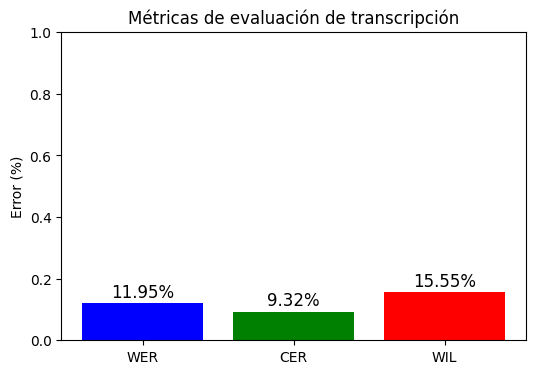

In [122]:
# Nombres y valores de las métricas
metrics = ["WER", "CER", "WIL"]
values = [wer_mean, cer_mean, wil_mean]

# Crear el gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=["blue", "green", "red"])

# Etiquetas y título
plt.ylabel("Error (%)")
plt.title("Métricas de evaluación de transcripción")
plt.ylim(0, 1)  # Límite entre 0 y 100% (1 equivale a 100%)

# Agregar valores encima de cada barra
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2%}", ha="center", fontsize=12)

plt.show()

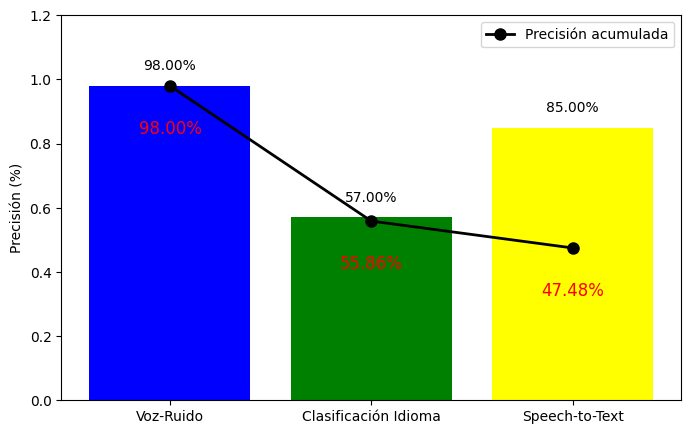

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Valores para las barras
bar_values = [0.98, 0.57, 0.85]  # Los valores de las barras en porcentaje (98%, 57%, 85%)
bar_labels = ['Voz-Ruido', 'Clasificación Idioma', 'Speech-to-Text']

# Valores para la línea
line_values = [0.98, 0.5586, 0.4748]  # Los valores de la línea en porcentaje (98%, 55.86%, 47.48%)

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(8, 5))

# Crear las barras
bars = ax.bar(bar_labels, bar_values, color=['blue', 'green', 'yellow'])

# Crear la línea
ax.plot(bar_labels, line_values, color='black', marker='o', linestyle='-', linewidth=2, markersize=8, label="Precisión acumulada")

# Etiquetas y título
ax.set_ylabel("Precisión (%)")
#ax.set_title("Gráfico de barras con línea de transición")
ax.set_ylim(0, 1.2)  # Límite entre 0 y 100% (1 equivale a 100%)

# Agregar valores encima de cada barra
for i, v in enumerate(bar_values):
    ax.text(i, v + 0.05, f"{v * 100:.2f}%", ha="center", fontsize=10)

for i, v in enumerate(line_values):
    ax.text(i, v - 0.15, f"{v * 100:.2f}%", ha="center", fontsize=12, color='red')

# Agregar la leyenda
ax.legend()

# Mostrar gráfico
plt.show()

C:\Users\Pedro\AppData\Local\Temp\ipykernel_15188\1879950908.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bar_labels, y=bar_values, palette='cubehelix', ax=ax)


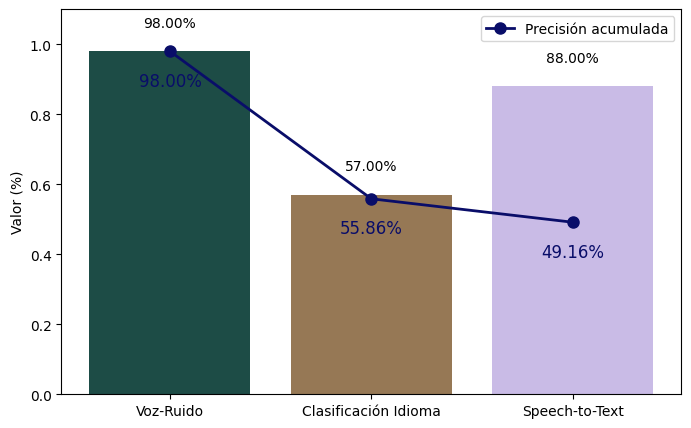

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Valores para las barras
bar_values = [0.98, 0.57, 0.88]  # Los valores de las barras en porcentaje (98%, 57%, 85%)
bar_labels = ['Voz-Ruido', 'Clasificación Idioma', 'Speech-to-Text']

# Valores para la línea
line_values = [0.98, 0.5586, 0.4916]  # Los valores de la línea en porcentaje (98%, 55.86%, 47.48%)

# Crear gráfico
fig, ax = plt.subplots(figsize=(8, 5))

# Crear las barras con seaborn
sns.barplot(x=bar_labels, y=bar_values, palette='cubehelix', ax=ax)

# Crear la línea
ax.plot(bar_labels, line_values, color='#090d69', marker='o', linestyle='-', linewidth=2, markersize=8, label="Precisión acumulada")

# Etiquetas y título
ax.set_ylabel("Valor (%)")
#ax.set_title("Gráfico de barras con línea de transición")
ax.set_ylim(0, 1.1)  # Límite entre 0 y 100% (1 equivale a 100%)

# Agregar valores encima de cada barra
for i, v in enumerate(bar_values):
    ax.text(i, v + 0.07, f"{v * 100:.2f}%", ha="center", fontsize=10, )

# Agregar valores debajo de los puntos de la línea
for i, v in enumerate(line_values):
    #if i == 0:
    #    continue
    ax.text(i, v - 0.1, f"{v * 100:.2f}%", ha="center", fontsize=12, color='#090d69')

# Agregar la leyenda
ax.legend()